In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import wfdb
%matplotlib inline
import hmmlearn
import pywt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA

In [2]:
np.random.seed(4200)

### Introduction and HMM fit for one waveform


In [3]:
def pos_probability(w_coefs, means, sigma,wavesize):
    #Predict emmission probabilities
    #Compute posterior probabilities for C1 and C2
    
    P=np.empty((2,wavesize),dtype=float)
    Pnorm=np.empty((2,wavesize),dtype=float)
    for j in range(wavesize):
        for i in range(2):
            p=np.exp(-0.5*(((w_coefs[:,j]-means[:,i]).dot(np.linalg.inv(sigma[:,:,i]))).dot((w_coefs[:,j]-means[:,i]).T)))
            P[i,j]=p/np.sqrt(2*np.pi*np.linalg.det(sigma[:,:,i]))
        Pnorm[:,j]=P[:,j]/np.sum(P[:,j])
    return Pnorm

In [4]:
def Viterbi(Pnorm, T, wavesize):
    #Pnorm - normalized emission probabilities
    #T - Normalized transition probabilities
    #wavesize=sample size
    Pv=np.zeros((2,wavesize),dtype=float)
    B=np.zeros((2,wavesize),dtype=int)
    V_state=np.zeros((1,wavesize),dtype=int)

    Pv[:,0]=Pnorm[:,0]
    for j in range(wavesize-1):

        for i in range(2):
            b=np.argmax(np.multiply(T[:,i],Pv[:,j]))
            B[i,j+1]=b
            Pv[i,j+1]=T[b,i]*Pv[b,j]*Pnorm[i,j+1]
        Pv[:,j+1]=Pv[:,j+1]/np.sum(Pv[:,j+1])

    V_state=np.zeros((1,wavesize),dtype=int)
    for k in range(wavesize-2, -1, -1):
        V_state[0,k]=B[np.argmax(Pv[:,k+1]),k+1]
    return V_state

### Define metrics
Metrics to find R-peak detection efficiency-
$$Sensitivity(Recall)=\frac{TP}{TP+FN}$$
$$PPR(Precision)=\frac{TP}{TP+FP}$$
$$DER=\frac{FN+FP}{TP+FN}$$
$$Accuracy=\frac{TP}{TP+FP+FN}$$

Average state duration near R-peak

TP when V_State=1 when R peak = True

FP when V_State=1 when R peak = False

FN when V_State=0 when R peak = True

As HMM tends to keep its state over the entire R-wave, we will discount any V_State=1 samples in the immediate vicinity(10 samples on each side) of expected R-peak from being counted as False Positives. 

In [5]:
def metrics(V_state,r_expected):
#True Positives - when V_State=1 when R peak = True
    TP=sum(V_state[0][r_expected])

    #False negative - when V_State=0 when R peak = True
    FN=len(r_expected)-TP

    #FP when V_State=1 when R peak = False / number of state transitions that are not R-peaks
    #get total number of State 0 to State 1 transitions and subtract the number of transitions in the 10-sample vicinity of Expected R-peak
    FP=0

    V_state[0][0]=0
    for i in range(len(V_state[0])-1):

        if (V_state[0][i]==0 and V_state[0][i+1]==1):
            if i<r_expected[-1]-2 and r_expected[r_expected>i+1][0]>=(i+10):
                FP+=1
            else:
                FP+=1

    state_duration=[]            
    for j in r_expected:
        if V_state[0][j]==1:
            state_start=j-np.where(np.flip(V_state[0][:j])==0)[0][0]+1
            state_end=j+np.where(V_state[0][j:]==0)[0][0]
            state_duration.append(state_end-state_start+1)    

    Sensitivity=TP/(TP+FN)
    PPR=TP/(TP+FP)
    DER=(FN+FP)/(TP+FN)
    avg_state_duration=np.mean(state_duration)
    return Sensitivity,PPR,DER,avg_state_duration



### Different training strategies for entire dataset
Create training and test dataset - explain method

In [6]:
#Train and test dataset
train_waves=[]
test_waves=[]

ecg_fnums=[100,101,103,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,123,124,201,202,203,205,207,208,209,210,212,213,214,215,217,219,220,221,222,223, 228, 230, 231, 232, 233, 234]
for fnum in ecg_fnums:
    #Load data and annotations
    record = wfdb.rdrecord('C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\data\\'+str(fnum),sampto=15000)
    annotation = wfdb.rdann('C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\data\\'+str(fnum), 'atr',sampto=15000)
    window_size=250
    num_r_peak=annotation.ann_len
    
    #To avoid picking up truncated waves, skip ECG waves that have position of R-peak < window_size 
    #also skip the last ECG wave in the input record
    R_pos=annotation.sample
    R_pos=R_pos[R_pos>window_size][:-1]
    
    np.random.shuffle(R_pos)
    split_pt=np.round(0.7*len(R_pos)).astype(int)
    train_r_idx=R_pos[:split_pt]
    test_r_idx=R_pos[split_pt:]
    
    for i in range(len(train_r_idx)):
        train_waves.append(record.p_signal[:,0][train_r_idx[i]-100:train_r_idx[i]+150])
        
    for i in range(len(test_r_idx)):
        test_waves.append(record.p_signal[:,0][test_r_idx[i]-100:test_r_idx[i]+150])    

#Hstack all training and testing waves to compute mean and variance using GMM
X_train=np.hstack(np.array(train_waves))
X_test=np.hstack(np.array(test_waves))

In [7]:
#export training and testing datasets as .mat
np.savetxt("C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\X_train.csv", X_train, delimiter=",")
np.savetxt("C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\X_test.csv", X_test, delimiter=",")
np.savetxt("C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\train_waves.csv", np.asarray(train_waves), delimiter=",")
np.savetxt("C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\test_waves.csv", np.asarray(test_waves), delimiter=",")

In [7]:
#Compute wavelet transform coefficients for training and test waves
#select detailed coeffs for scale 2,3,4 
coefs_train=pywt.cwt(X_train, wavelet='mexh',scales=[1,2,3,4])[0][1:4]

coefs_test=pywt.cwt(X_test, wavelet='mexh',scales=[1,2,3,4])[0][1:4]

In [9]:
#During creation of train and test data, each wave is segmented in such a way that the R-peak is at the 100th position of a 250 sample wide wave
r_expected_train=np.arange(100,174500,250)
r_expected_test=np.arange(100,174500,250)

In [10]:
#Define transmission probabilities
T=np.array([[0.7,0.3],[0.3,0.7]])

In [11]:
#evaluation on unknown wave
fnum=200
record = wfdb.rdrecord('C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\data\\'+str(fnum),sampto=15000)
annotation = wfdb.rdann('C:\\Users\\hsalil89\\Documents\\DS\\MLSP\\Project\\data\\'+str(fnum), 'atr',sampto=15000)

X_test_new=record.p_signal[:,0]
r_expected_test_new=annotation.sample

coefs_test_new=pywt.cwt(X_test_new, wavelet='mexh',scales=[1,2,3,4])[0][1:4]

In [13]:
result=pd.DataFrame(columns=['Training method','Evaluation method','Sensitivity','PPR','DER','avg_Rstate_duration'])

#### use template ECG signal to train -
Why cant we use a ecg wave template as training dataset for R-peak detection? Arrythmia impacts time as well as amplitude. Shape may change causing deterioration in classification metrics.
Give example waves and metrics

In [14]:
##Train GMM using only one sample wave from the training dataset
coefs_1 = pywt.cwt(X_train[0:250], wavelet='mexh',scales=[1,2,3,4])[0][1:4]

#Predict mean and variance using GMM
g1 = GaussianMixture(n_components=2,random_state=4200)
g1.fit(coefs_1.T)
means_1=g1.means_.T
sigma_1=g1.covariances_.T

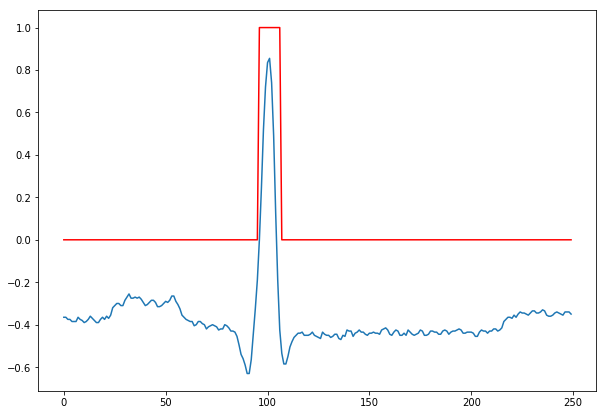

In [15]:
#Compute Emission probabilities
Pnorm=pos_probability(coefs_1, means_1, sigma_1,250)

#compute best hidden state sequence for given input
V_state=Viterbi(Pnorm, T, wavesize=250)

#Plot the states sequence diagram
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
ax1.plot(X_train[0:250])
ax1.plot(V_state[0],'r')

In [16]:
##Evaluate method on test dataset
#Compute Emission probabilities
Pnorm_1=pos_probability(coefs_test, means_1, sigma_1,174500)
#compute best hidden state sequence for given input
V_state_1=Viterbi(Pnorm_1, T, wavesize=174500)
#Metrics
Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_1,r_expected_test)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Template training wave','Test dataset',Sensitivity,PPR,DER,avg_state_duration]

0.43982808022922637 0.2033112582781457 2.2836676217765044 7.136807817589577


In [17]:
##Evaluate method on unknown test dataset
#Compute Emission probabilities
Pnorm_1_new=pos_probability(coefs_test_new, means_1, sigma_1,15000)
#compute best hidden state sequence for given input
V_state_1_new=Viterbi(Pnorm_1_new, T, wavesize=15000)
#metrics
Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_1_new,r_expected_test_new)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Template training wave','unknown ECG signal',Sensitivity,PPR,DER,avg_state_duration]

0.06349206349206349 0.03361344537815126 2.761904761904762 7.0


#### use entire training wave to train the model -


In [18]:
#Predict mean and variance using GMM
g2 = GaussianMixture(n_components=2,random_state=4200)
g2.fit(coefs_train.T)
means_2=g2.means_.T
sigma_2=g2.covariances_.T

In [21]:
#Switching the columns to align to the proper class label (0-no R, 1-R-wave)
s_2=np.sum(means_2,axis=0)
if s_2[0]>s_2[1]:
    means_2[:,[0,1]]=means_2[:,[1,0]]
    sigma_2[:,:,[0,1]]=sigma_2[:,:,[1,0]]

In [20]:
#Evaluate method on test dataset
#Compute Emission probabilities
Pnorm_2=pos_probability(coefs_test, means_2, sigma_2,174500)

#compute best hidden state sequence for given input
V_state_2=Viterbi(Pnorm_2, T, wavesize=174500)

Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_2,r_expected_test)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['training dataset','Test dataset',Sensitivity,PPR,DER,avg_state_duration]

0.9856733524355301 0.2235217673814165 3.438395415472779 38.57994186046512


In [21]:
##Evaluate method on unknown test dataset
#Compute Emission probabilities
Pnorm_2_new=pos_probability(coefs_test_new, means_2, sigma_2,15000)
#compute best hidden state sequence for given input
V_state_2_new=Viterbi(Pnorm_2_new, T, wavesize=15000)
#metrics
Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_2_new,r_expected_test_new)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Training dataset','unknown ECG signal',Sensitivity,PPR,DER,avg_state_duration]

0.9682539682539683 0.2629310344827586 2.746031746031746 39.295081967213115


#### use feature enhancement using PCA on wavelet coeffs of entire training wave to train the model -

In [22]:
pca=PCA(n_components=3,random_state=4200)

In [23]:
w_pca_train=pca.fit_transform(coefs_train.T)
#Predict mean and variance using GMM
g3 = GaussianMixture(n_components=2,random_state=4200)
g3.fit(w_pca_train)
means_3=g3.means_.T
sigma_3=g3.covariances_.T

In [27]:
#Switching the columns to align to the proper class label (0-no R, 1-R-wave)
s_3=np.sum(means_3,axis=0)
if s_3[0]>s_3[1]:
    means_3[:,[0,1]]=means_3[:,[1,0]]
    sigma_3[:,:,[0,1]]=sigma_3[:,:,[1,0]]

In [25]:
#Evaluate method on test dataset
w_pca_test=pca.transform(coefs_test.T)

#Compute Emission probabilities
Pnorm_3=pos_probability(w_pca_test.T, means_3, sigma_3,174500)

#compute best hidden state sequence for given input
V_state_3=Viterbi(Pnorm_3, T, wavesize=174500)

Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_3,r_expected_test)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Training dataset+PCA','Test dataset',Sensitivity,PPR,DER,avg_state_duration]

0.9856733524355301 0.2235217673814165 3.438395415472779 38.57994186046512


In [26]:
##Evaluate method on unknown test dataset
w_pca_test_new=pca.transform(coefs_test_new.T)
#Compute Emission probabilities
Pnorm_3_new=pos_probability(w_pca_test_new.T, means_3, sigma_3,15000)
#compute best hidden state sequence for given input
V_state_3_new=Viterbi(Pnorm_3_new, T, wavesize=15000)
#metrics
Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_3_new,r_expected_test_new)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Training dataset+PCA','unknown ECG signal',Sensitivity,PPR,DER,avg_state_duration]

0.9682539682539683 0.2629310344827586 2.746031746031746 39.295081967213115


#### use feature enhancement using ICA on wavelet coeffs of entire training wave to train the model -

In [27]:
ica=FastICA(n_components=3,random_state=4200)

In [28]:
w_ica_train=ica.fit_transform(coefs_train.T)
#Predict mean and variance using GMM
g4 = GaussianMixture(n_components=2,random_state=4200)
g4.fit(w_ica_train)
means_4=g4.means_.T
sigma_4=g4.covariances_.T

In [33]:
#Switching the columns to align to the proper class label (0-no R, 1-R-wave)
s_4=np.sum(means_4,axis=0)
if s_4[0]>s_4[1]:
    means_4[:,[0,1]]=means_4[:,[1,0]]
    sigma_4[:,:,[0,1]]=sigma_4[:,:,[1,0]]

In [30]:
#Evaluate method on test dataset
w_ica_test=ica.transform(coefs_test.T)

#Compute Emission probabilities
Pnorm_4=pos_probability(w_ica_test.T, means_4, sigma_4,174500)

#compute best hidden state sequence for given input
V_state_4=Viterbi(Pnorm_4, T, wavesize=174500)

Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_4,r_expected_test)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Training dataset+ICA','Test dataset',Sensitivity,PPR,DER,avg_state_duration]

0.9297994269340975 0.32662304982385504 1.987106017191977 20.805855161787367


In [31]:
##Evaluate method on unknown test dataset
w_ica_test_new=ica.transform(coefs_test_new.T)
#Compute Emission probabilities
Pnorm_4_new=pos_probability(w_ica_test_new.T, means_4, sigma_4,15000)
#compute best hidden state sequence for given input
V_state_4_new=Viterbi(Pnorm_4_new, T, wavesize=15000)
#metrics
Sensitivity,PPR,DER,avg_state_duration=metrics(V_state_4_new,r_expected_test_new)
print(Sensitivity,PPR,DER,avg_state_duration)
k=result.shape[0]+1
result.loc[k]=['Training dataset+ICA','unknown ECG signal',Sensitivity,PPR,DER,avg_state_duration]

0.9523809523809523 0.29850746268656714 2.2857142857142856 13.533333333333333


### Outcome

In [32]:
result

,Training method,Evaluation method,Sensitivity,PPR,DER,avg_Rstate_duration
1,Template training wave,Test dataset,0.439828,0.203311,2.283668,7.136808
2,Template training wave,unknown ECG signal,0.063492,0.033613,2.761905,7.000000
3,training dataset,Test dataset,0.985673,0.223522,3.438395,38.579942
4,Training dataset,unknown ECG signal,0.968254,0.262931,2.746032,39.295082
5,Training dataset+PCA,Test dataset,0.985673,0.223522,3.438395,38.579942
6,Training dataset+PCA,unknown ECG signal,0.968254,0.262931,2.746032,39.295082
7,Training dataset+ICA,Test dataset,0.929799,0.326623,1.987106,20.805855
8,Training dataset+ICA,unknown ECG signal,0.952381,0.298507,2.285714,13.533333


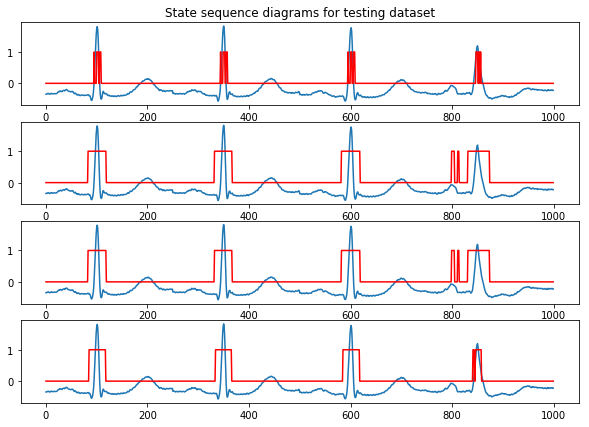

In [33]:
#Plot the states sequence diagram evaluation method 1
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(411)
ax1.plot(X_test[10000:11000])
ax1.plot(V_state_1[0][10000:11000],'r')
plt.title('State sequence diagrams for testing dataset')
ax1=fig.add_subplot(412)
ax1.plot(X_test[10000:11000])
ax1.plot(V_state_2[0][10000:11000],'r')
ax1=fig.add_subplot(413)
ax1.plot(X_test[10000:11000])
ax1.plot(V_state_3[0][10000:11000],'r')
ax1=fig.add_subplot(414)
ax1.plot(X_test[10000:11000])
ax1.plot(V_state_4[0][10000:11000],'r')

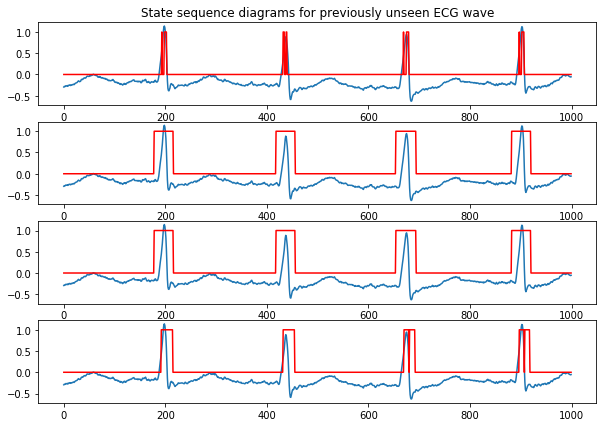

In [34]:
#Plot the states sequence diagram evaluation method 2
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(411)
ax1.plot(X_test_new[10000:11000])
ax1.plot(V_state_1_new[0][10000:11000],'r')
plt.title('State sequence diagrams for previously unseen ECG wave')
ax1=fig.add_subplot(412)
ax1.plot(X_test_new[10000:11000])
ax1.plot(V_state_2_new[0][10000:11000],'r')
ax1=fig.add_subplot(413)
ax1.plot(X_test_new[10000:11000])
ax1.plot(V_state_3_new[0][10000:11000],'r')
ax1=fig.add_subplot(414)
ax1.plot(X_test_new[10000:11000])
ax1.plot(V_state_4_new[0][10000:11000],'r')